# Evaluating Entity Relationship Extraction with DSPy & Fine-Tune Prompt Instructions

## Steps
- Load DSPy examples (separated into train, val, dev) that are saved locally.
- Evaluate the extraction module with the dev examples to determine the baseline scores, i.e: the fine-tuned extraction module should score higher.
- Run bootstrapping with random search with train examples, evaluate its compiled extraction module on the same dev examples to compare against baseline scores.
- Run MIPROv2 with train and dev examples, evaluate its compiled extraction module on the same dev examples to compare against baseline and bootstrapping with random search scores.

## Why Use MIPROv2?
MIPROv2 is an optimizer that generates candidate few-shot examples and instructions for each prompt in the extraction module, and then optimizes over the fewshot examples and instructions as hyperparameters for a number of batches. For each batch, the optimizer evaluates different combinations of prompts on a subset of training inputs and learns the combinations that maximizes performance. This optimizer is quite useful when dealing with a large number of training examples. 

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import dspy
from dspy.teleprompt import BootstrapFewShotWithRandomSearch, MIPROv2
from dspy.evaluate import Evaluate
import os
import numpy as np
from dotenv import load_dotenv
import logging
import pickle
import matplotlib.pyplot as plt

from nano_graphrag.entity_extraction.module import TypedEntityRelationshipExtractor
from nano_graphrag.entity_extraction.metric import relationships_similarity_metric, entity_recall_metric

/opt/homebrew/Caskroom/miniconda/base/envs/nano-graphrag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
WORKING_DIR = "./nano_graphrag_cache_finetune_entity_relationship_dspy"
EXAMPLES_DIR = "./nano_graphrag_cache_generate_dspy_examples"
load_dotenv()

logging.basicConfig(level=logging.WARNING)
logging.getLogger("nano-graphrag").setLevel(logging.DEBUG)

np.random.seed(1337)

In [4]:
system_prompt = """
    You are a world-class AI system, capable of complex reasoning and reflection. 
    Reason through the query, and then provide your final response. 
    If you detect that you made a mistake in your reasoning at any point, correct yourself.
    Think carefully.
"""
deepseek = dspy.OpenAI(
    model="deepseek-chat", 
    model_type="chat",
    api_key=os.environ["DEEPSEEK_API_KEY"], 
    base_url=os.environ["DEEPSEEK_BASE_URL"], 
    system_prompt=system_prompt, 
    temperature=1.0,
    max_tokens=8192
)
qwen2 = dspy.OllamaLocal(
    model="qwen2", 
    system=system_prompt,
    temperature=1.0,
    max_tokens=4096,
    num_ctx=32000,
    format="json",
    timeout_s=240,
)
dspy.settings.configure(lm=deepseek, experimental=True)

In [5]:
os.makedirs(WORKING_DIR, exist_ok=True)
entity_relationship_rs_path = os.path.join(WORKING_DIR, "entity_relationship_extraction_news_rs.json")
entity_relationship_miprov2_path = os.path.join(WORKING_DIR, "entity_relationship_extraction_news_miprov2.json")
entity_relationship_trainset_path = os.path.join(EXAMPLES_DIR, "entity_relationship_extraction_news_trainset.pkl")
entity_relationship_valset_path = os.path.join(EXAMPLES_DIR, "entity_relationship_extraction_news_valset.pkl")
entity_relationship_devset_path = os.path.join(EXAMPLES_DIR, "entity_relationship_extraction_news_devset.pkl")

trainset = pickle.load(open(entity_relationship_trainset_path, "rb"))
valset = pickle.load(open(entity_relationship_valset_path, "rb"))
devset = pickle.load(open(entity_relationship_devset_path, "rb"))

In [ ]:
for example in trainset:
    for relationship in example.relationships:
        if relationship['order'] == 2:
            print(relationship)

In [ ]:
for example in trainset:
    for relationship in example.relationships:
        if relationship['order'] == 3:
            print(relationship)

In [ ]:
trainset[0].relationships[:2]

In [ ]:
valset[0].relationships[:2]

In [ ]:
for example in valset:
    for relationship in example.relationships:
        if relationship['order'] == 2:
            print(relationship)

In [ ]:
for example in valset:
    for relationship in example.relationships:
        if relationship['order'] == 3:
            print(relationship)

In [ ]:
devset[0].relationships[:2]

In [ ]:
for example in devset:
    for relationship in example.relationships:
        if relationship['order'] == 2:
            print(relationship)

In [ ]:
for example in devset:
    for relationship in example.relationships:
        if relationship['order'] == 3:
            print(relationship)

In [6]:
model = TypedEntityRelationshipExtractor()
model

extractor.predictor.predictor = Predict(StringSignature(input_text, entity_types -> reasoning, entities_relationships
    instructions='Given a text document that is potentially relevant to this activity and a list of entity types, \nidentify all entities of those types from the text and all relationships among the identified entities.\n\nEntity Guidelines:\n1. Each entity name should be an actual atomic word from the input text. \n2. Avoid duplicates and generic terms.\n3. Make sure descriptions are detailed and comprehensive. Use multiple complete sentences for each point below:\n    a). The entity\'s role or significance in the context\n    b). Key attributes or characteristics\n    c). Relationships to other entities (if applicable)\n    d). Historical or cultural relevance (if applicable)\n    e). Any notable actions or events associated with the entity\n4. All entity types from the text must be included. \n5. IMPORTANT: Only use entity types from the provided \'entity_types\' lis

In [12]:
metrics = [entity_recall_metric, relationships_similarity_metric]
baseline_scores = []
for metric in metrics:
    evaluate = Evaluate(
        devset=devset[:20], 
        metric=metric, 
        num_threads=os.cpu_count(), 
        display_progress=True,
        display_table=5,
    )
    baseline_scores.append(evaluate(model))

  0%|          | 0/20 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

,input_text,example_entities,example_relationships,pred_entities,pred_relationships,entity_recall_metric
0,"As students from Marjory Stoneman Douglas High School confront lawmakers with demands to restrict sales of assault rifles, there were warnings by the president of...","[{'entity_name': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'entity_type': 'ORGANIZATION', 'description': 'A high school in Florida where students confronted lawmakers about restricting sales of assault rifles.', 'importance_score':...","[{'src_id': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'tgt_id': 'FLORIDA', 'description': 'Students from Marjory Stoneman Douglas High School are located in the state of Florida.', 'weight': 0.9,...","[{'entity_name': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'entity_type': 'ORGANIZATION', 'description': 'A high school in Florida where students confronted lawmakers about assault rifle sales.', 'importance_score': 0.9}, {'entity_name':...","[{'src_id': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'tgt_id': 'FLORIDA', 'description': 'Marjory Stoneman Douglas High School is located in Florida.', 'weight': 0.9, 'order': 1}, {'src_id': 'LAURENZO PRADO',...",✔️ [0.6666666666666666]
1,"From ferrying people to and from their place of work to transporting nuclear waste and coal, railways are not only an integral part of 21st...","[{'entity_name': 'RAILNOVA', 'entity_type': 'ORGANIZATION', 'description': 'A technology company based in Brussels whose clients include Deutsche Bahn and French rail operator SNCF.', 'importance_score': 0.9}, {'entity_name': 'DEUTSCHE...","[{'src_id': 'RAILNOVA', 'tgt_id': 'DEUTSCHE BAHN', 'description': 'Railnova provides technology solutions to Deutsche Bahn.', 'weight': 0.9, 'order': 1}, {'src_id': 'RAILNOVA', 'tgt_id': 'SNCF', 'description': 'Railnova provides technology...","[{'entity_name': 'RAILNOVA', 'entity_type': 'ORGANIZATION', 'description': 'A technology company based in Brussels whose clients include Deutsche Bahn and French rail operator SNCF.', 'importance_score': 0.9}, {'entity_name': 'DEUTSCHE...","[{'src_id': 'RAILNOVA', 'tgt_id': 'DEUTSCHE BAHN', 'description': 'Railnova provides technology solutions to Deutsche Bahn.', 'weight': 0.8, 'order': 1}, {'src_id': 'RAILNOVA', 'tgt_id': 'SNCF', 'description': 'Railnova provides technology...",✔️ [0.8888888888888888]
2,Jan 22 (Reuters) - Shanghai Stock Exchange Filing * SHOWS BLOCK TRADE OF YONGHUI SUPERSTORES Co LTd's 166.3 MILLION SHARES INVOLVING 1.63 BILLION YUAN ($254.68...,"[{'entity_name': 'YONGHUI SUPERSTORES CO LTD', 'entity_type': 'ORGANIZATION', 'description': 'YONGHUI SUPERSTORES Co LTd is involved in a block trade of 166.3 million shares.', 'importance_score': 1.0}, {'entity_name':...","[{'src_id': 'YONGHUI SUPERSTORES CO LTD', 'tgt_id': '166.3 MILLION SHARES', 'description': 'YONGHUI SUPERSTORES Co LTd is involved in a block trade of 166.3 million shares.', 'weight':...","[{'entity_name': 'SHANGHAI STOCK EXCHANGE', 'entity_type': 'ORGANIZATION', 'description': 'The Shanghai Stock Exchange is a stock exchange located in Shanghai, China.', 'importance_score': 0.9}, {'entity_name': 'YONGHUI SUPERSTORES CO...","[{'src_id': 'SHANGHAI STOCK EXCHANGE', 'tgt_id': 'YONGHUI SUPERSTORES CO LTD', 'description': 'The Shanghai Stock Exchange filed a block trade involving YONGHUI SUPERSTORES Co Ltd.', 'weight': 0.9,...",✔️ [0.8]
3,"LONDON (Reuters) - Britain’s economy was weaker than previously thought in 2017, official data showed on Thursday, leaving the country lagging further behind the global...","[{'entity_name': 'BRITAIN', 'entity_type': 'LOCATION', 'description': 'The country whose economy was weaker than previously thought in 2017.', 'importance_score': 0.9}, {'entity_name': 'EUROPEAN UNION', 'entity_type': 'ORGANIZATION', 'description': 'The...","[{'src_id': 'BRITAIN', 'tgt_id': 'EUROPEAN UNION', 'description': 'Britain is preparing to leave the European Union.', 'weight': 0.9, 'order': 1}, {'src_id': 'BANK OF ENGLAND', 'tgt_id': 'INTEREST RATES'

  0%|          | 0/20 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

,input_text,example_entities,example_relationships,pred_entities,pred_relationships,relationships_similarity_metric
0,"As students from Marjory Stoneman Douglas High School confront lawmakers with demands to restrict sales of assault rifles, there were warnings by the president of...","[{'entity_name': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'entity_type': 'ORGANIZATION', 'description': 'A high school in Florida where students confronted lawmakers about restricting sales of assault rifles.', 'importance_score':...","[{'src_id': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'tgt_id': 'FLORIDA', 'description': 'Students from Marjory Stoneman Douglas High School are located in the state of Florida.', 'weight': 0.9,...","[{'entity_name': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'entity_type': 'ORGANIZATION', 'description': 'A high school in Florida where students confronted lawmakers about assault rifle sales.', 'importance_score': 0.9}, {'entity_name':...","[{'src_id': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'tgt_id': 'FLORIDA', 'description': 'Marjory Stoneman Douglas High School is located in Florida.', 'weight': 0.9, 'order': 1}, {'src_id': 'LAURENZO PRADO',...",✔️ [0.45]
1,"From ferrying people to and from their place of work to transporting nuclear waste and coal, railways are not only an integral part of 21st...","[{'entity_name': 'RAILNOVA', 'entity_type': 'ORGANIZATION', 'description': 'A technology company based in Brussels whose clients include Deutsche Bahn and French rail operator SNCF.', 'importance_score': 0.9}, {'entity_name': 'DEUTSCHE...","[{'src_id': 'RAILNOVA', 'tgt_id': 'DEUTSCHE BAHN', 'description': 'Railnova provides technology solutions to Deutsche Bahn.', 'weight': 0.9, 'order': 1}, {'src_id': 'RAILNOVA', 'tgt_id': 'SNCF', 'description': 'Railnova provides technology...","[{'entity_name': 'RAILNOVA', 'entity_type': 'ORGANIZATION', 'description': 'A technology company based in Brussels whose clients include Deutsche Bahn and French rail operator SNCF.', 'importance_score': 0.9}, {'entity_name': 'DEUTSCHE...","[{'src_id': 'RAILNOVA', 'tgt_id': 'DEUTSCHE BAHN', 'description': 'Railnova provides technology solutions to Deutsche Bahn.', 'weight': 0.8, 'order': 1}, {'src_id': 'RAILNOVA', 'tgt_id': 'SNCF', 'description': 'Railnova provides technology...",✔️ [0.75]
2,Jan 22 (Reuters) - Shanghai Stock Exchange Filing * SHOWS BLOCK TRADE OF YONGHUI SUPERSTORES Co LTd's 166.3 MILLION SHARES INVOLVING 1.63 BILLION YUAN ($254.68...,"[{'entity_name': 'YONGHUI SUPERSTORES CO LTD', 'entity_type': 'ORGANIZATION', 'description': 'YONGHUI SUPERSTORES Co LTd is involved in a block trade of 166.3 million shares.', 'importance_score': 1.0}, {'entity_name':...","[{'src_id': 'YONGHUI SUPERSTORES CO LTD', 'tgt_id': '166.3 MILLION SHARES', 'description': 'YONGHUI SUPERSTORES Co LTd is involved in a block trade of 166.3 million shares.', 'weight':...","[{'entity_name': 'SHANGHAI STOCK EXCHANGE', 'entity_type': 'ORGANIZATION', 'description': 'The Shanghai Stock Exchange is a stock exchange located in Shanghai, China.', 'importance_score': 0.9}, {'entity_name': 'YONGHUI SUPERSTORES CO...","[{'src_id': 'SHANGHAI STOCK EXCHANGE', 'tgt_id': 'YONGHUI SUPERSTORES CO LTD', 'description': 'The Shanghai Stock Exchange filed a block trade involving YONGHUI SUPERSTORES Co Ltd.', 'weight': 0.9,...",✔️ [0.8]
3,"LONDON (Reuters) - Britain’s economy was weaker than previously thought in 2017, official data showed on Thursday, leaving the country lagging further behind the global...","[{'entity_name': 'BRITAIN', 'entity_type': 'LOCATION', 'description': 'The country whose economy was weaker than previously thought in 2017.', 'importance_score': 0.9}, {'entity_name': 'EUROPEAN UNION', 'entity_type': 'ORGANIZATION', 'description': 'The...","[{'src_id': 'BRITAIN', 'tgt_id': 'EUROPEAN UNION', 'description': 'Britain is preparing to leave the European Union.', 'weight': 0.9, 'order': 1}, {'src_id': 'BANK OF ENGLAND', 'tgt_id': 'INTEREST RATES',...","[{'entity_

In [8]:
deepseek.inspect_history(n=1)




Assess the similarity between gold and predicted relationships:
1. Match relationships based on src_id and tgt_id pairs, allowing for slight variations in entity names.
2. For matched pairs, compare:
   a) Description similarity (semantic meaning)
   b) Weight similarity
   c) Order similarity
3. Consider unmatched relationships as penalties.
4. Aggregate scores, accounting for precision and recall.
5. Return a final similarity score between 0 (no similarity) and 1 (perfect match).

Key considerations:
- Prioritize matching based on entity pairs over exact string matches.
- Use semantic similarity for descriptions rather than exact matches.
- Weight the importance of different aspects (e.g., entity matching, description, weight, order).
- Balance the impact of matched and unmatched relationships in the final score.

---

Follow the following format.

Gold Relationships: The gold-standard relationships to compare against.

Predicted Relationships: The predicted relationships to compa

'\n\n\nAssess the similarity between gold and predicted relationships:\n1. Match relationships based on src_id and tgt_id pairs, allowing for slight variations in entity names.\n2. For matched pairs, compare:\n   a) Description similarity (semantic meaning)\n   b) Weight similarity\n   c) Order similarity\n3. Consider unmatched relationships as penalties.\n4. Aggregate scores, accounting for precision and recall.\n5. Return a final similarity score between 0 (no similarity) and 1 (perfect match).\n\nKey considerations:\n- Prioritize matching based on entity pairs over exact string matches.\n- Use semantic similarity for descriptions rather than exact matches.\n- Weight the importance of different aspects (e.g., entity matching, description, weight, order).\n- Balance the impact of matched and unmatched relationships in the final score.\n\n---\n\nFollow the following format.\n\nGold Relationships: The gold-standard relationships to compare against.\n\nPredicted Relationships: The predic

In [ ]:
optimizer = BootstrapFewShotWithRandomSearch(
    metric=relationships_similarity_metric, 
    num_threads=os.cpu_count(),
    num_candidate_programs=10,
    max_labeled_demos=5,
    max_bootstrapped_demos=2,
)
rs_model = optimizer.compile(model, trainset=trainset, valset=valset)
rs_model

In [ ]:
metrics = [entity_recall_metric, relationships_similarity_metric]
for metric in metrics:
    evaluate = Evaluate(
        devset=devset, 
        metric=metric, 
        num_threads=os.cpu_count(), 
        display_progress=True,
        display_table=5,
    )
    evaluate(rs_model)

In [ ]:
rs_model.save(entity_relationship_rs_path)

## MIPROv2
- Let's take a small LLM to complete the entity relationship extraction, while making a larger LLM create the prompt instructions and few-shot examples.
- Feel free to generate sufficient amount of train dataset to avoid overfitting.

In [7]:
optimizer = MIPROv2(
    prompt_model=deepseek,
    task_model=qwen2,
    metric=entity_recall_metric,
    init_temperature=1.4,
    num_candidates=10,
    verbose=False
)
kwargs = dict(num_threads=os.cpu_count(), display_progress=True, display_table=0)
miprov2_model = optimizer.compile(
    model, 
    trainset=trainset[:50],
    valset=valset[:20],
    requires_permission_to_run=False,
    num_batches=20, 
    max_labeled_demos=5, 
    max_bootstrapped_demos=3, 
    eval_kwargs=kwargs
)
miprov2_model


Please be advised that based on the parameters you have set, the maximum number of LM calls is projected as follows:


- Prompt Model: 10 data summarizer calls + 10 * 1 lm calls in program + (2) lm calls in program aware proposer = 22 prompt model calls
- Task Model: 25 examples in minibatch * 20 batches + 50 examples in train set * 2 full evals = 600 task model calls

Estimated Cost Calculation:

Total Cost = (Number of calls to task model * (Avg Input Token Length per Call * Task Model Price per Input Token + Avg Output Token Length per Call * Task Model Price per Output Token) 
            + (Number of calls to prompt model * (Avg Input Token Length per Call * Task Prompt Price per Input Token + Avg Output Token Length per Call * Prompt Model Price per Output Token).

For a preliminary estimate of potential costs, we recommend you perform your own calculations based on the task
and prompt models you intend to use. If the projected costs exceed your budget or expectations, you may c

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


b: 10


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


b: 20


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


b: 30


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


b: 40


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


summary: Prediction(
    summary='The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key entities are highlighted with importance scores, and multimedia elements are prevalent, making it suitable for natural language processing and information extraction tasks.'
)
DATA SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key entities are highlighted with importance scores, and multimedia elements are prevalent, making it suitable for natural language processing and information extraction tasks.


  6%|▌         | 3/50 [03:56<1:01:47, 78.88s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


  4%|▍         | 2/50 [01:10<28:02, 35.06s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


  2%|▏         | 1/50 [00:00<00:00, 165.86it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


  2%|▏         | 1/50 [00:46<37:34, 46.02s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


  2%|▏         | 1/50 [00:59<48:39, 59.58s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


  2%|▏         | 1/50 [00:57<47:20, 57.97s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


  6%|▌         | 3/50 [03:45<58:47, 75.05s/it]  


Bootstrapped 3 full traces after 4 examples in round 0.


  6%|▌         | 3/50 [02:59<46:53, 59.87s/it]


Bootstrapped 3 full traces after 4 examples in round 0.
Using a randomly generated configuration for our grounded proposer.
Selected tip: description


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to solve the task of extracting entities and relationships from a given text input. It uses a pipeline that involves a language model to perform this extraction. The program works by defining a signature that specifies the input fields (input_text and entity_types) and the output fields (reasoning and entities_relationships). The TypedPredictor class ensures that the type annotations in the signature are enforced, and it handles retries and error explanations if the output is invalid. The TypedEntityRelationshipExtractor class integrates this predictor to extract entities and relationships from the input text, converting the results into a structured format. The program uses a combination of type checking, JSON schema validation, and language model predictions to achieve its task.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos 


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to solve the task of extracting entities and relationships from input text. It works by first identifying entities in the text based on provided entity types, then determining the relationships between these entities considering their interactions and dependencies within the context of the text. Finally, it formats the entities and relationships according to a specified JSON schema. The program uses a pipeline that includes a language model to perform these tasks, ensuring type annotations and handling retries and errors in the extraction process.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos Input Text: Melbourne, Australia (CNN)After spending part of the off-season training with Mike Tyson, Serena Williams is hoping to deliver a knockout punch at the Australian Open. Follow @cnnsport

For Williams that would mean winning a record-tying 24th grand slam title, which has so far proved elusive despite getting close four times since returning to the tour after giving birth to daughter Alexis Olympia. Her preparation for the year's first major couldn't have gone much better, suggesting the mini grand slam drought for arguably tennis' greatest ever player is about to cease. Williams let rip into a punching bag in December -- drawing a compliment from former heavyweight boxing champion Tyson, whose daughter happens to be a budding tennis star -- and then won a buildup tournament in Auckland last week to incredibly land a title in a fourth straight decade. She also mingled with one of tennis' youngest sensations, Coco Gauff, as part of the training camp in Florida organ

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to solve the task of extracting entities and their relationships from a given text. It works by first identifying entities in the text based on predefined entity types, then determining the relationships between these entities considering their interactions and the context provided in the text. The program ensures that each entity and relationship is described comprehensively and assigned appropriate importance scores and weights. The output is formatted according to a specified JSON schema, listing entities and their relationships in a structured manner.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos Input Text:  (CNN)Former Bosnian Serb army leader Ratko Mladic was sentenced to life in prison Wednesday after being found guilty of genocide for atrocities committed during the Bosnian war from 1992 to 1995.Verdict proceedings had been interrupted earlier when the 74-year-old's legal team claimed that his blood pressure was too high to continue.After outbursts from Mladic, Judge Alphons Orie, who was delivering a summation of the case, ordered the removal of the ex-general, telling him he could monitor proceedings by audio and video. "I am very distraught," Mladic shouted inside the courtroom. "Everything that you have said is pure lies. Shame on you. It's all lies."Mladic's legal team had asked for proceedings to be halted or for the summation of the case to be skipped, which the Judge refused. Read MoreMladic was charged with two counts of genocide and nine crimes against humanity and war crimes for his role in the conflict in the former Yugoslavia from 1992 to 1995, duri

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to solve the task of extracting entities and their relationships from a given text input. It works by first identifying entities in the text based on specified entity types. Then, it determines the relationships between these entities, considering their interactions and dependencies within the context of the text. Finally, it formats the entities and relationships according to a specified JSON schema. The program uses a language model to perform these tasks and includes mechanisms for error handling and retries to ensure accurate results.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos Input Text:  (CNN)The New York City Marathon returns on Sunday following a two-year hiatus, and at the front of the field, legendary distance runner Kenenisa Bekele is primed to "make more history" in his storied career. Bekele, a three-time Olympic gold medalist over 5,000 and 10,000 meters, is the headline name competing in the men's elite field in New York. With his only previous marathon in the United States a fourth-place finish in Chicago seven years ago, the Ethiopian is hungry for success as he prepares to take to the streets of the Big Apple."Really, I wanted to have a good result in the USA, that's why I chose the New York marathon," Bekele told reporters this week."The New York marathon is big publicity and a really big marathon race. To achieve a good result in this marathon would be perfect, and for me, it's also really good to make more history in sports."Read MoreBekele has a point to prove after a disappointing outing six weeks ago at the Berlin Marathon -- t

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to solve the task of extracting entities and their relationships from a given text. It uses a language model to identify entities based on specified types and then determines the relationships between these entities. The program works by first defining a signature that includes input fields for the text and entity types, and output fields for reasoning and the extracted entities and relationships. It then uses a TypedPredictor to enforce type annotations and handle potential errors, ensuring that the output matches the expected format. The program iteratively attempts to extract and validate the entities and relationships, providing explanations for errors and suggesting corrections if necessary. Finally, it returns the extracted entities and their relationships in a structured format.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos Input Text:  (CNN)Roger Federer thinks the professional tennis circuit won't return for a while due to the coronavirus pandemic but, when the time does come, the Swiss superstar said he would find it difficult to play without fans. While European football's Bundesliga resurfaced last week behind closed doors and Spain's La Liga is set to resume the middle of next month, the last official word from tennis authorities essentially saw all action suspended through July. The hiatus began in March, with Federer already sidelined since he was recuperating from knee surgery. Sunday would have marked the first day of the French Open in its usual spot on the tennis calendar -- in March, though, it was rescheduled for September -- and another grand slam, Wimbledon in July, was called off. "I'm not training at the moment because I don't see a reason for that to be honest," Federer told three-time French Open champion Gustavo Kuerten -- who is raising funds for coronavirus relief efforts

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to solve the task of entity and relationship extraction from a given text. It works by taking an input text and a list of entity types, then using a language model to identify entities within the text that match the provided types. After identifying the entities, the program determines the relationships between these entities based on their interactions and dependencies within the context of the text. The process involves generating reasoning steps to justify the extraction, and the final output is a list of entities with their types, descriptions, and importance scores, along with relationships between these entities, including descriptions, weights, and order. The program ensures type safety and validation through the use of Pydantic models and retries the extraction process up to a specified number of times if errors are encountered.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos Input Text: Story highlightsThe Man v Fat soccer league is exclusively for men with a body mass index of 30 or moreThe league helps players lose weight, but it also gives them a built-in support group (CNN)After reviewing restaurants for years, Andrew Shanahan became obese and was looking for a way to lose weight.But it wasn't easy to find a program tailored to men. Every time he tried joining a weight-loss group, he was the only man in the room. "I wondered how many other men felt that there was something missing and who weren't getting the support that you desperately need when you're trying to lose weight," he said.So in 2014, with the help of a crowdfunding campaign, Shanahan launched his Man v Fat initiative to reach out to other men like him. The idea drew attention from celebrities such as chef Jamie Oliver, and Shanahan was encouraged to write a book on it the next year. Being based in England, a soccer league seemed like a natural outreach program. And Shanahan rece

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to extract entities and relationships from a given text based on specified entity types. It uses a language model to perform this task, ensuring that the output adheres to strict type annotations and JSON schemas. The program follows a structured approach: it first identifies entities in the text according to the provided entity types, then determines the relationships between these entities based on their interactions and dependencies within the context of the text, and finally formats the entities and relationships according to a predefined JSON schema. The program includes error handling and retry mechanisms to ensure the output meets the required specifications.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos Input Text: London (CNN)Prince Philip, the husband of Queen Elizabeth II, is being treated for an infection and is not expected to leave the hospital for several days, according to an update from Buckingham Palace on Tuesday."The Duke of Edinburgh remains at King Edward VII's Hospital where he is receiving medical attention for an infection. He is comfortable and responding to treatment but is not expected to leave hospital for several days," the palace said in a statement.Prince Philip was taken to the hospital last Tuesday after "feeling unwell," Buckingham Palace said.On Monday, his grandson, Prince William, said the 99-year-old was doing "OK" and hospital staff were "keeping an eye on him."Queen Elizabeth and Duke of Edinburgh receive Covid-19 vaccinePrince William made the remarks during a visit to a vaccination center in Norfolk, England, on Monday.Read MoreOn Tuesday, Prince Philip's youngest son, Prince Edward, told the UK's Sky News that he recently spoke to his fat

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to solve the task of entity and relationship extraction from text. It works by first defining a signature that specifies the input fields (input_text and entity_types) and the output fields (reasoning and entities_relationships). The program then uses a TypedPredictor class to enforce type annotations in the signature and handle retries and error explanations if the output is invalid. The TypedEntityRelationshipExtractor class further processes the input text to extract entities and relationships, ensuring that the output is formatted according to the specified JSON schema. The program handles retries and errors by providing detailed explanations and examples to guide the language model in producing the correct output format.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos Input Text:  (CNN)This weekend either Lewis Hamilton or Max Verstappen will be crowned the Formula One world champion. Either way, the sport won big in 2021. This year's success starts with a boom in the sport's fanbase that can be pinned to Netflix's "Drive to Survive" docuseries. The show is a crash course on the 10 teams, the 20 drivers, the rivalries between them and the race competition structure. A word-of-mouth campaign for the series along with short, easy viewing episodes made it a perfect pandemic-time binge watch for millions around the world.The series' intimate interviews combined with the best action from races and the high level drama is a strong pitch for the real-life spectacle of Formula One.The multifaceted storytelling lets fans focus on the aspects of the sport that most appeal to them. And most importantly, "Drive to Survive" primed fans for an easy transition to the track when the 2021 season started.Read MoreThe popularity of the Netflix program, nota

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


PROGRAM DESCRIPTION: The program is designed to solve the task of extracting entities and relationships from text, specifically focusing on identifying entities based on predefined types and determining the relationships between these entities. It works by using a language model to process the input text and entity types, generating a step-by-step reasoning process to identify and relate the entities, and finally outputting the entities and their relationships in a structured JSON format. The program ensures type annotations are enforced and includes mechanisms for handling errors and retries to improve the accuracy of the output.


INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"


task_demos Input Text:  (CNN)A ban on cellphones in classrooms was announced in the Australian state of Victoria on Wednesday. The ban, which will apply to primary and secondary students, is designed to crack down on cyber-bulling and classroom distractions, the Victorian government said in a statement. While some schools in Australia have already banned cell-phone use, this marks the first statewide ban in the country. It will begin from the first school term of 2020."Students will be required to switch off their phones and store them securely in lockers from the start of the school day until the final bell. When emergencies occur, parents or guardians can reach their child by calling the school," the statement said.Victoria Education Minister James Merlino said he didn't expect the move to be "universally popular" but said it was the "right thing to do" on his official social media. Read MoreA report says young people are growing horns on their skulls. Critics don't buy itThe move is

INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
/opt/homebrew/Caskroom/miniconda/base/envs/nano-graphrag/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-09-20 18:37:04,086] A new study created in memory with name: no-name-80b7b333-e37b-4380-94c7-15183cc4517f
INFO:root:Starting trial num: 0
INFO:root:instruction_idx 1
INFO:root:demos_idx 2





Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to prompt a Language Model to perform this task.

---

DATASET SUMMARY: The dataset consists of news articles from CNN, covering a wide range of topics with a structured format including headlines, summaries, and detailed bodies. Key

  0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

FULL TRACE


Average Metric: 0.9375 / 1  (93.8): 100%|██████████| 1/1 [00:00<00:00, 2849.39it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T22:40:14.777811Z [info     ] Average Metric: 0.9375 / 1 (93.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218




...
Score 83.66
Best Combination: 1,{0: [[], [Example({'input_text': ' (CNN)Roger Federer thinks the professional tennis circuit won\'t return for a while due to the coronavirus pandemic but, when the time does come, the Swiss superstar said he would find it difficult to play without fans. While European football\'s Bundesliga resurfaced last week behind closed doors and Spain\'s La Liga is set to resume the middle of next month, the last official word from tennis authorities essentially saw all action suspended through July. The hiatus began in March, with Federer already sidelined since he was recuperating from knee surgery. Sunday would have marked the first day of the French Open in its usual spot on the tennis calendar -- in March, though, it was rescheduled for September -- and another grand slam, Wimbledon in July, was called off. "I\'m not training at the moment because I don\'t see a reason for that to be honest," Federer told three-time French Open champion Gustavo Kuerten 

Average Metric: 15.645833333333336 / 18  (86.9):  34%|███▍      | 17/50 [00:00<00:00, 6314.49it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deeps

UPDATING BEST SCORE WITH 81.23


  0%|          | 0/20 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text`, identify all entities that match the provided `entity_types`. For each identified entity, provide its `entity_name`, `entity_type`, `description`, and `importance_score`. Then, determine the relationships between these entities, including the `src_id` (source entity), `tgt_id` (target entity), `description` of the relationship, `weight` of the relationship, and `order` of the relationship. Ensure that the relationships are based on interactions and dependencies within the context of the text.
p: Entities Relationships:


...


Average Metric: 21.12777777777778 / 25  (84.5): 100%|██████████| 25/25 [00:00<00:00, 5120.00it/s] 
INFO:dspy.evaluate.evaluate:2024-09-20T22:45:51.882004Z [info     ] Average Metric: 21.12777777777778 / 25 (84.5%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218


FULL TRACE


Average Metric: 0.9375 / 1  (93.8): 100%|██████████| 1/1 [00:00<00:00, 4905.62it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T22:45:51.889152Z [info     ] Average Metric: 0.9375 / 1 (93.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 18:45:51,893] Trial 1 finished with value: 84.51 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 2}. Best is trial 1 with value: 84.51.
INFO:root:Starting trial num: 2
INFO:root:instruction_idx 8
INFO:root:demos_idx 6




...
Score 84.51
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, meticulously identify and extract all entities present in the text that match the provided entity types. Subsequently, determine the relationships between these entities based on their interactions and the context provided. Ensure that the entities and relationships are formatted according to the specified JSON schema, including providing detailed descriptions and importance scores for each entity, as well as defining the source and target IDs, description, weight, and order for each relationship.
p: Entities Relationships:


...


  0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

FULL TRACE


Average Metric: 0.75 / 1  (75.0): 100%|██████████| 1/1 [00:00<00:00, 1633.93it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T22:49:13.507498Z [info     ] Average Metric: 0.75 / 1 (75.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 18:49:13,514] Trial 2 finished with value: 89.67 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 6}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 3
INFO:root:instruction_idx 4
INFO:root:demos_idx 5




...
Score 89.67
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, meticulously extract entities and their relationships from the text. First, identify all entities in the text that match the provided entity types, ensuring each entity includes its name, type, a brief description, and an importance score. Next, determine the relationships between these entities by analyzing their interactions and dependencies within the context of the text. Each relationship should include the source entity ID, target entity ID, a description of the relationship, a weight indicating the strength of the relationship, and an order indicating the sequence of the relationship. Finally, format the entities and relationships according to the specified JSON schema, ensuring all fields are correctly populated and validated.
p: Entities Relationships:


...


  0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

FULL TRACE


Average Metric: 0.375 / 1  (37.5): 100%|██████████| 1/1 [00:00<00:00, 1968.23it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T22:51:23.857461Z [info     ] Average Metric: 0.375 / 1 (37.5%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 18:51:23,864] Trial 3 finished with value: 58.05 and parameters: {'0_predictor_instruction': 4, '0_predictor_demos': 5}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 4
INFO:root:instruction_idx 3
INFO:root:demos_idx 8




...
Score 58.05
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and `entity_types`, meticulously identify and extract entities from the text. For each identified entity, provide a comprehensive description and assign an importance score. Subsequently, determine the relationships between these entities, considering their interactions and the context provided in the text. Each relationship should include a description and appropriate weight. Ensure that the output is formatted according to the specified JSON schema, listing entities and their relationships in a structured manner.
p: Entities Relationships:


...


  0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

FULL TRACE


Average Metric: 0.625 / 1  (62.5): 100%|██████████| 1/1 [01:34<00:00, 94.34s/it]
INFO:dspy.evaluate.evaluate:2024-09-20T22:56:19.164784Z [info     ] Average Metric: 0.625 / 1 (62.5%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 18:56:19,172] Trial 4 finished with value: 82.99 and parameters: {'0_predictor_instruction': 3, '0_predictor_demos': 8}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 5
INFO:root:instruction_idx 2
INFO:root:demos_idx 3




...
Score 82.99
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, identify and extract all entities within the text that match the specified entity types. After identifying the entities, determine the relationships between these entities based on their interactions and dependencies within the context of the text. Ensure that the extracted entities and relationships are formatted according to the specified JSON schema, including the fields `entity_name`, `entity_type`, `description`, `importance_score` for entities, and `src_id`, `tgt_id`, `description`, `weight`, and `order` for relationships. Provide a detailed step-by-step reasoning process to justify the extraction and relationship determination.
p: Entities Relationships:


...


  0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

FULL TRACE


Average Metric: 0.375 / 1  (37.5): 100%|██████████| 1/1 [00:00<00:00, 3498.17it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T22:58:44.357714Z [info     ] Average Metric: 0.375 / 1 (37.5%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 18:58:44,362] Trial 5 finished with value: 75.11 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 3}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 6
INFO:root:instruction_idx 9
INFO:root:demos_idx 5




...
Score 75.11
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, your task is to meticulously extract entities and their relationships from the text. First, identify all entities in the text that match the provided entity types. Then, analyze the context to determine the relationships between these entities, considering their interactions and dependencies within the text. Finally, format the identified entities and their relationships according to the specified JSON schema, ensuring all fields are accurately populated with relevant details such as entity names, types, descriptions, and importance scores for entities, and source IDs, target IDs, descriptions, weights, and orders for relationships.
p: Entities Relationships:


...


Average Metric: 9.38531746031746 / 15  (62.6):  56%|█████▌    | 14/25 [00:00<00:00, 4799.76it/s] INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepse

FULL TRACE


Average Metric: 0.375 / 1  (37.5): 100%|██████████| 1/1 [00:00<00:00, 2409.13it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:00:14.890670Z [info     ] Average Metric: 0.375 / 1 (37.5%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:00:14,896] Trial 6 finished with value: 59.24 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 5}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 7
INFO:root:instruction_idx 7
INFO:root:demos_idx 4




...
Score 59.24
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and `entity_types`, perform the following steps to produce the `entities_relationships`: 1) Identify all entities within the `input_text` that match the specified `entity_types`. 2) For each identified entity, provide a detailed description and an importance score based on its relevance to the text. 3) Determine the relationships between the identified entities, considering their interactions and dependencies within the context of the `input_text`. 4) For each relationship, provide a description, a weight indicating the strength of the relationship, and an order indicating the sequence of interactions. 5) Format the entities and relationships according to the specified JSON schema, ensuring all fields adhere to the required types and structures.
p: Entities Relationships:


...


  0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

FULL TRACE


Average Metric: 0.6875 / 1  (68.8): 100%|██████████| 1/1 [01:38<00:00, 98.40s/it]
INFO:dspy.evaluate.evaluate:2024-09-20T23:05:02.031146Z [info     ] Average Metric: 0.6875 / 1 (68.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:05:02,043] Trial 7 finished with value: 85.12 and parameters: {'0_predictor_instruction': 7, '0_predictor_demos': 4}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 8
INFO:root:instruction_idx 0
INFO:root:demos_idx 7




...
Score 85.12
CANDIDATE PROGRAM:
Predictor 0
i: Given the fields `input_text`, `entity_types`, produce the fields `entities_relationships`.
p: Entities Relationships:


...


  0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

FULL TRACE


Average Metric: 0.6875 / 1  (68.8): 100%|██████████| 1/1 [01:30<00:00, 90.45s/it]
INFO:dspy.evaluate.evaluate:2024-09-20T23:09:34.668729Z [info     ] Average Metric: 0.6875 / 1 (68.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:09:34,677] Trial 8 finished with value: 86.51 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 7}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 9
INFO:root:instruction_idx 9
INFO:root:demos_idx 7




...
Score 86.51
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, your task is to meticulously extract entities and their relationships from the text. First, identify all entities in the text that match the provided entity types. Then, analyze the context to determine the relationships between these entities, considering their interactions and dependencies within the text. Finally, format the identified entities and their relationships according to the specified JSON schema, ensuring all fields are accurately populated with relevant details such as entity names, types, descriptions, and importance scores for entities, and source IDs, target IDs, descriptions, weights, and orders for relationships.
p: Entities Relationships:


...


Average Metric: 6.419444444444444 / 8  (80.2):  28%|██▊       | 7/25 [00:00<00:00, 4399.84it/s] INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepsee

FULL TRACE


Average Metric: 0.6875 / 1  (68.8): 100%|██████████| 1/1 [00:00<00:00, 3269.14it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:11:41.304268Z [info     ] Average Metric: 0.6875 / 1 (68.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:11:41,308] Trial 9 finished with value: 83.8 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 7}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 10
INFO:root:instruction_idx 5
INFO:root:demos_idx 6




...
Score 83.8
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and `entity_types`, meticulously identify and extract entities from the text. For each identified entity, provide its `entity_name`, `entity_type`, a concise `description`, and an `importance_score`. Subsequently, determine and list the relationships between these entities, specifying the `src_id` (source entity), `tgt_id` (target entity), a `description` of the relationship, a `weight` indicating the strength of the relationship, and an `order` to indicate the sequence of relationships. Ensure that the relationships are coherent and directly derived from the context provided in the `input_text`.
p: Entities Relationships:


...


Average Metric: 10.449248120300751 / 12  (87.1):  44%|████▍     | 11/25 [00:00<00:00, 4796.98it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deeps

FULL TRACE


Average Metric: 0.75 / 1  (75.0): 100%|██████████| 1/1 [00:00<00:00, 3833.92it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:13:48.274109Z [info     ] Average Metric: 0.75 / 1 (75.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218




...
Score 84.6
Best Combination: 8,{0: [[], [Example({'input_text': ' (CNN)Roger Federer thinks the professional tennis circuit won\'t return for a while due to the coronavirus pandemic but, when the time does come, the Swiss superstar said he would find it difficult to play without fans. While European football\'s Bundesliga resurfaced last week behind closed doors and Spain\'s La Liga is set to resume the middle of next month, the last official word from tennis authorities essentially saw all action suspended through July. The hiatus began in March, with Federer already sidelined since he was recuperating from knee surgery. Sunday would have marked the first day of the French Open in its usual spot on the tennis calendar -- in March, though, it was rescheduled for September -- and another grand slam, Wimbledon in July, was called off. "I\'m not training at the moment because I don\'t see a reason for that to be honest," Federer told three-time French Open champion Gustavo Kuerten -

Average Metric: 29.13139097744361 / 33  (88.3):  64%|██████▍   | 32/50 [00:00<00:00, 2565.57it/s] INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deeps

UPDATING BEST SCORE WITH 85.16


  0%|          | 0/20 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, meticulously identify and extract all entities present in the text that match the provided entity types. Subsequently, determine the relationships between these entities based on their interactions and the context provided. Ensure that the entities and relationships are formatted according to the specified JSON schema, including providing detailed descriptions and importance scores for each entity, as well as defining the source and target IDs, description, weight, and order for each relationship.
p: Entities Relationships:


...


Average Metric: 21.475396825396825 / 25  (85.9): 100%|██████████| 25/25 [00:00<00:00, 5185.58it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:17:15.221858Z [info     ] Average Metric: 21.475396825396825 / 25 (85.9%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218


FULL TRACE


Average Metric: 0.75 / 1  (75.0): 100%|██████████| 1/1 [00:00<00:00, 4563.99it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:17:15.228964Z [info     ] Average Metric: 0.75 / 1 (75.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:17:15,233] Trial 11 finished with value: 85.9 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 6}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 12
INFO:root:instruction_idx 0
INFO:root:demos_idx 7




...
Score 85.9
CANDIDATE PROGRAM:
Predictor 0
i: Given the fields `input_text`, `entity_types`, produce the fields `entities_relationships`.
p: Entities Relationships:


...


Average Metric: 17.793849206349208 / 21  (84.7):  80%|████████  | 20/25 [00:00<00:00, 3941.09it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
Average Metric: 20.849404761904765 / 25  (83.4): 100%|██████████| 25/25 [01:09<00:00,  2.77s/it]  
INFO:dspy.evaluate.evaluate:2024-09-20T23:18:24.543416Z [info     ] Average Metric: 20.849404761904765 / 25 (83.4%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218


FULL TRACE


Average Metric: 0.6875 / 1  (68.8): 100%|██████████| 1/1 [00:00<00:00, 3844.46it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:18:24.553425Z [info     ] Average Metric: 0.6875 / 1 (68.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:18:24,558] Trial 12 finished with value: 83.4 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 7}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 13
INFO:root:instruction_idx 8
INFO:root:demos_idx 0




...
Score 83.4
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, meticulously identify and extract all entities present in the text that match the provided entity types. Subsequently, determine the relationships between these entities based on their interactions and the context provided. Ensure that the entities and relationships are formatted according to the specified JSON schema, including providing detailed descriptions and importance scores for each entity, as well as defining the source and target IDs, description, weight, and order for each relationship.
p: Entities Relationships:


...


Average Metric: 1.0 / 1  (100.0):   0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completi

FULL TRACE


Average Metric: 0.9375 / 1  (93.8): 100%|██████████| 1/1 [00:00<00:00, 2061.08it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:26:48.397803Z [info     ] Average Metric: 0.9375 / 1 (93.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:26:48,404] Trial 13 finished with value: 85.42 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 0}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 14
INFO:root:instruction_idx 0
INFO:root:demos_idx 6




...
Score 85.42
CANDIDATE PROGRAM:
Predictor 0
i: Given the fields `input_text`, `entity_types`, produce the fields `entities_relationships`.
p: Entities Relationships:


...


Average Metric: 20.842502088554724 / 25  (83.4): 100%|██████████| 25/25 [00:00<00:00, 5090.67it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:26:48.510647Z [info     ] Average Metric: 20.842502088554724 / 25 (83.4%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218


FULL TRACE


Average Metric: 0.75 / 1  (75.0): 100%|██████████| 1/1 [00:00<00:00, 4951.95it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:26:48.517720Z [info     ] Average Metric: 0.75 / 1 (75.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:26:48,522] Trial 14 finished with value: 83.37 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 6}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 15
INFO:root:instruction_idx 8
INFO:root:demos_idx 9




...
Score 83.37
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, meticulously identify and extract all entities present in the text that match the provided entity types. Subsequently, determine the relationships between these entities based on their interactions and the context provided. Ensure that the entities and relationships are formatted according to the specified JSON schema, including providing detailed descriptions and importance scores for each entity, as well as defining the source and target IDs, description, weight, and order for each relationship.
p: Entities Relationships:


...


  0%|          | 0/25 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

FULL TRACE


Average Metric: 0.5 / 1  (50.0): 100%|██████████| 1/1 [00:00<00:00, 1694.67it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:29:34.675482Z [info     ] Average Metric: 0.5 / 1 (50.0%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:29:34,681] Trial 15 finished with value: 73.18 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 9}. Best is trial 2 with value: 89.67.
INFO:root:Starting trial num: 16
INFO:root:instruction_idx 0
INFO:root:demos_idx 1




...
Score 73.18
CANDIDATE PROGRAM:
Predictor 0
i: Given the fields `input_text`, `entity_types`, produce the fields `entities_relationships`.
p: Entities Relationships:


...


Average Metric: 17.57559523809524 / 20  (87.9):  76%|███████▌  | 19/25 [00:00<00:00, 1862.52it/s] INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
Average Metric: 22.422963659147868 / 25  (89.7): 100%|██████████| 25/25 [02:09<00:00,  5.17s/it] 
INFO:dspy.evaluate.evaluate:2024-09-20T23:31:44.061856Z [info     ] Average Metric: 22.422963659147868 / 25 (89.7%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218


FULL TRACE


Average Metric: 0.9375 / 1  (93.8): 100%|██████████| 1/1 [00:00<00:00, 2387.20it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:31:44.082846Z [info     ] Average Metric: 0.9375 / 1 (93.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:31:44,089] Trial 16 finished with value: 89.69 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 1}. Best is trial 16 with value: 89.69.
INFO:root:Starting trial num: 17
INFO:root:instruction_idx 4
INFO:root:demos_idx 1




...
Score 89.69
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and a list of `entity_types`, meticulously extract entities and their relationships from the text. First, identify all entities in the text that match the provided entity types, ensuring each entity includes its name, type, a brief description, and an importance score. Next, determine the relationships between these entities by analyzing their interactions and dependencies within the context of the text. Each relationship should include the source entity ID, target entity ID, a description of the relationship, a weight indicating the strength of the relationship, and an order indicating the sequence of the relationship. Finally, format the entities and relationships according to the specified JSON schema, ensuring all fields are correctly populated and validated.
p: Entities Relationships:


...


Average Metric: 17.161257309941522 / 20  (85.8):  76%|███████▌  | 19/25 [00:00<00:00, 4993.22it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
Average Metric: 21.95014619883041 / 25  (87.8): 100%|██████████| 25/25 [01:15<00:00,  3.03s/it]   
INFO:dspy.evaluate.evaluate:2024-09-20T23:33:00.017116Z [info     ] Average Metric: 21.95014619883041 / 25 (87.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218


FULL TRACE


Average Metric: 0.9375 / 1  (93.8): 100%|██████████| 1/1 [00:00<00:00, 2083.61it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:33:00.038879Z [info     ] Average Metric: 0.9375 / 1 (93.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:33:00,045] Trial 17 finished with value: 87.8 and parameters: {'0_predictor_instruction': 4, '0_predictor_demos': 1}. Best is trial 16 with value: 89.69.
INFO:root:Starting trial num: 18
INFO:root:instruction_idx 0
INFO:root:demos_idx 1




...
Score 87.8
CANDIDATE PROGRAM:
Predictor 0
i: Given the fields `input_text`, `entity_types`, produce the fields `entities_relationships`.
p: Entities Relationships:


...


Average Metric: 17.972817460317458 / 20  (89.9):  76%|███████▌  | 19/25 [00:00<00:00, 4408.46it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
Average Metric: 22.6156746031746 / 25  (90.5): 100%|██████████| 25/25 [01:00<00:00,  2.43s/it]    
INFO:dspy.evaluate.evaluate:2024-09-20T23:34:00.907729Z [info     ] Average Metric: 22.6156746031746 / 25 (90.5%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218


FULL TRACE


Average Metric: 0.9375 / 1  (93.8): 100%|██████████| 1/1 [00:00<00:00, 2189.09it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:34:00.929783Z [info     ] Average Metric: 0.9375 / 1 (93.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:34:00,936] Trial 18 finished with value: 90.46 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 1}. Best is trial 18 with value: 90.46.
INFO:root:Starting trial num: 19
INFO:root:instruction_idx 5
INFO:root:demos_idx 1




...
Score 90.46
CANDIDATE PROGRAM:
Predictor 0
i: Given the `input_text` and `entity_types`, meticulously identify and extract entities from the text. For each identified entity, provide its `entity_name`, `entity_type`, a concise `description`, and an `importance_score`. Subsequently, determine and list the relationships between these entities, specifying the `src_id` (source entity), `tgt_id` (target entity), a `description` of the relationship, a `weight` indicating the strength of the relationship, and an `order` to indicate the sequence of relationships. Ensure that the relationships are coherent and directly derived from the context provided in the `input_text`.
p: Entities Relationships:


...


Average Metric: 20.263043024227233 / 25  (81.1): 100%|██████████| 25/25 [00:56<00:00,  2.25s/it]  
INFO:dspy.evaluate.evaluate:2024-09-20T23:34:57.310459Z [info     ] Average Metric: 20.263043024227233 / 25 (81.1%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218


FULL TRACE


Average Metric: 0.9375 / 1  (93.8): 100%|██████████| 1/1 [00:00<00:00, 2207.53it/s]
INFO:dspy.evaluate.evaluate:2024-09-20T23:34:57.332555Z [info     ] Average Metric: 0.9375 / 1 (93.8%) [dspy.evaluate.evaluate] filename=evaluate.py lineno=218
[I 2024-09-20 19:34:57,339] Trial 19 finished with value: 81.05 and parameters: {'0_predictor_instruction': 5, '0_predictor_demos': 1}. Best is trial 18 with value: 90.46.




...
Score 81.05


extractor.predictor.predictor = Predict(StringSignature(input_text, entity_types -> reasoning, entities_relationships
    instructions='Given the `input_text` and a list of `entity_types`, meticulously identify and extract all entities present in the text that match the provided entity types. Subsequently, determine the relationships between these entities based on their interactions and the context provided. Ensure that the entities and relationships are formatted according to the specified JSON schema, including providing detailed descriptions and importance scores for each entity, as well as defining the source and target IDs, description, weight, and order for each relationship.'
    input_text = Field(annotation=str required=True json_schema_extra={'desc': 'The text to extract entities and relationships from.', '__dspy_field_type': 'input', 'prefix': 'Input Text:'})
    entity_types = Field(annotation=list[str] required=True json_schema_extra={'desc': 'List of entity types used fo

In [9]:
deepseek.inspect_history(n=1)




Given the fields `input_text`, `entity_types`, produce the fields `entities_relationships`.

---

Follow the following format.

Input Text: The text to extract entities and relationships from.

Entity Types: List of entity types used for extraction.

Reasoning: Let's think step by step in order to ${produce the entities_relationships}. We ...

Entities Relationships: List of entities and relationships extracted from the text.. Respond with a single JSON object. JSON Schema: {"$defs": {"Entity": {"properties": {"entity_name": {"description": "The name of the entity.", "title": "Entity Name", "type": "string"}, "entity_type": {"description": "The type of the entity.", "title": "Entity Type", "type": "string"}, "description": {"description": "The description of the entity, in details and comprehensive.", "title": "Description", "type": "string"}, "importance_score": {"description": "Importance score of the entity. Should be between 0 and 1 with 1 being the most important.", "maximum": 

'\n\n\nGiven the fields `input_text`, `entity_types`, produce the fields `entities_relationships`.\n\n---\n\nFollow the following format.\n\nInput Text: The text to extract entities and relationships from.\n\nEntity Types: List of entity types used for extraction.\n\nReasoning: Let\'s think step by step in order to ${produce the entities_relationships}. We ...\n\nEntities Relationships: List of entities and relationships extracted from the text.. Respond with a single JSON object. JSON Schema: {"$defs": {"Entity": {"properties": {"entity_name": {"description": "The name of the entity.", "title": "Entity Name", "type": "string"}, "entity_type": {"description": "The type of the entity.", "title": "Entity Type", "type": "string"}, "description": {"description": "The description of the entity, in details and comprehensive.", "title": "Description", "type": "string"}, "importance_score": {"description": "Importance score of the entity. Should be between 0 and 1 with 1 being the most importa

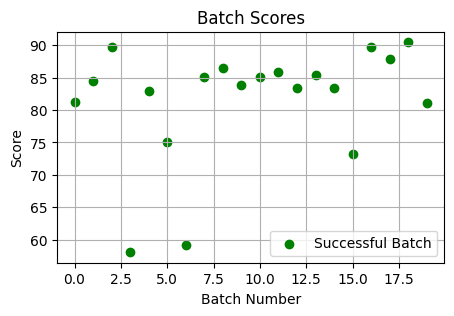

In [13]:
trial_logs = miprov2_model.trial_logs
trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]['score'] for trial in trial_numbers]
pruning_status = [trial_logs[trial]['pruned'] for trial in trial_numbers]

plt.figure(figsize=(5, 3))
for trial_number, score, pruned in zip(trial_numbers, scores, pruning_status):
    if pruned:
        plt.scatter(trial_number, score, color='grey', label='Pruned Batch' if 'Pruned Batch' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(trial_number, score, color='green', label='Successful Batch' if 'Successful Batch' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.title('Batch Scores')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
best_score = 0

def get_signature(predictor):
    if (hasattr(predictor, 'extended_signature')):
        return predictor.extended_signature
    elif (hasattr(predictor, 'signature')):
        return predictor.signature

print(f"Baseline program | Score: {best_score}:")
for i,predictor in enumerate(model.predictors()):
    print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
print()

print("----------------")

for trial_num in miprov2_model.trial_logs:
    program_score = miprov2_model.trial_logs[trial_num]["score"]
    program_pruned = miprov2_model.trial_logs[trial_num]["pruned"]
    if program_score > best_score and not program_pruned and miprov2_model.trial_logs[trial_num]["full_eval"]:
        best_score = program_score
        best_program_so_far = miprov2_model.trial_logs[trial_num]["program"]
    if trial_num % 5 == 0:
        print(f"Best program after {trial_num} batches | Score: {best_score}:")
        for i,predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
        print()

Baseline program | Score: 0:
Prompt 1 Instruction: Given the fields `input_text`, `entity_types`, produce the fields `entities_relationships`.

----------------
Best program after 0 batches | Score: 81.23:
Prompt 1 Instruction: Given the `input_text` and a list of `entity_types`, meticulously extract and identify all entities and their relationships within the text. Ensure that each entity is accurately classified according to the provided entity types, and clearly define the relationships between entities, including their descriptions, weights, and orders. Provide a step-by-step reasoning process to justify the extraction and classification of each entity and relationship.

Best program after 5 batches | Score: 81.23:
Prompt 1 Instruction: Given the `input_text` and a list of `entity_types`, meticulously extract and identify all entities and their relationships within the text. Ensure that each entity is accurately classified according to the provided entity types, and clearly define 

In [11]:
metrics = [entity_recall_metric, relationships_similarity_metric]
for metric in metrics:
    evaluate = Evaluate(
        devset=devset[:20], 
        metric=metric, 
        num_threads=os.cpu_count(), 
        display_progress=True,
        display_table=5,
    )
    evaluate(miprov2_model)

  0%|          | 0/20 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

,input_text,example_entities,example_relationships,pred_entities,pred_relationships,entity_recall_metric
0,"As students from Marjory Stoneman Douglas High School confront lawmakers with demands to restrict sales of assault rifles, there were warnings by the president of...","[{'entity_name': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'entity_type': 'ORGANIZATION', 'description': 'A high school in Florida where students confronted lawmakers about restricting sales of assault rifles.', 'importance_score':...","[{'src_id': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'tgt_id': 'FLORIDA', 'description': 'Students from Marjory Stoneman Douglas High School are located in the state of Florida.', 'weight': 0.9,...","[{'entity_name': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'entity_type': 'ORGANIZATION', 'description': 'A high school in Florida where a mass shooting occurred, leading to demands for restricting assault...","[{'src_id': 'NIKOLAS CRUZ', 'tgt_id': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'description': 'Nikolas Cruz carried out a mass shooting at Marjory Stoneman Douglas High School.', 'weight': 0.9,...",✔️ [1.0]
1,"From ferrying people to and from their place of work to transporting nuclear waste and coal, railways are not only an integral part of 21st...","[{'entity_name': 'RAILNOVA', 'entity_type': 'ORGANIZATION', 'description': 'A technology company based in Brussels whose clients include Deutsche Bahn and French rail operator SNCF.', 'importance_score': 0.9}, {'entity_name': 'DEUTSCHE...","[{'src_id': 'RAILNOVA', 'tgt_id': 'DEUTSCHE BAHN', 'description': 'Railnova provides technology solutions to Deutsche Bahn.', 'weight': 0.9, 'order': 1}, {'src_id': 'RAILNOVA', 'tgt_id': 'SNCF', 'description': 'Railnova provides technology...","[{'entity_name': 'RAILNOVA', 'entity_type': 'ORGANIZATION', 'description': 'A technology company based in Brussels that offers solutions to improve train operations.', 'importance_score': 0.9}, {'entity_name': 'CHRISTIAN SPRAUER', 'entity_type': 'PERSON',...","[{'src_id': 'CHRISTIAN SPRAUER', 'tgt_id': 'RAILNOVA', 'description': 'Christian Sprauer is the CEO and founder of Railnova.', 'weight': 0.9, 'order': 1}, {'src_id': 'RAILNOVA', 'tgt_id': 'DEUTSCHE BAHN', 'description':...",✔️ [0.8888888888888888]
2,Jan 22 (Reuters) - Shanghai Stock Exchange Filing * SHOWS BLOCK TRADE OF YONGHUI SUPERSTORES Co LTd's 166.3 MILLION SHARES INVOLVING 1.63 BILLION YUAN ($254.68...,"[{'entity_name': 'YONGHUI SUPERSTORES CO LTD', 'entity_type': 'ORGANIZATION', 'description': 'YONGHUI SUPERSTORES Co LTd is involved in a block trade of 166.3 million shares.', 'importance_score': 1.0}, {'entity_name':...","[{'src_id': 'YONGHUI SUPERSTORES CO LTD', 'tgt_id': '166.3 MILLION SHARES', 'description': 'YONGHUI SUPERSTORES Co LTd is involved in a block trade of 166.3 million shares.', 'weight':...","[{'entity_name': 'SHANGHAI STOCK EXCHANGE', 'entity_type': 'ORGANIZATION', 'description': ""A stock exchange where the block trade of YONGHUI SUPERSTORES Co Ltd's shares took place."", 'importance_score': 0.8}, {'entity_name':...","[{'src_id': 'SHANGHAI STOCK EXCHANGE', 'tgt_id': 'YONGHUI SUPERSTORES CO LTD', 'description': ""The block trade of YONGHUI SUPERSTORES Co Ltd's shares took place at the Shanghai Stock...",✔️ [0.8]
3,"LONDON (Reuters) - Britain’s economy was weaker than previously thought in 2017, official data showed on Thursday, leaving the country lagging further behind the global...","[{'entity_name': 'BRITAIN', 'entity_type': 'LOCATION', 'description': 'The country whose economy was weaker than previously thought in 2017.', 'importance_score': 0.9}, {'entity_name': 'EUROPEAN UNION', 'entity_type': 'ORGANIZATION', 'description': 'The...","[{'src_id': 'BRITAIN', 'tgt_id': 'EUROPEAN UNION', 'description': 'Britain is preparing to leave the European Union.', 'weight': 0.9, 'order': 1}, {'src_id': 'BANK OF ENGLAND', 'tgt_id': 'INTEREST RATES',...","[{'entity_name': 'BRITAIN', 'entity_type': 'LOCATION', 'description': 'The co

  0%|          | 0/20 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.deepseek.com/beta/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

,input_text,example_entities,example_relationships,pred_entities,pred_relationships,relationships_similarity_metric
0,"As students from Marjory Stoneman Douglas High School confront lawmakers with demands to restrict sales of assault rifles, there were warnings by the president of...","[{'entity_name': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'entity_type': 'ORGANIZATION', 'description': 'A high school in Florida where students confronted lawmakers about restricting sales of assault rifles.', 'importance_score':...","[{'src_id': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'tgt_id': 'FLORIDA', 'description': 'Students from Marjory Stoneman Douglas High School are located in the state of Florida.', 'weight': 0.9,...","[{'entity_name': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'entity_type': 'ORGANIZATION', 'description': 'A high school in Florida where a mass shooting occurred, leading to demands for restricting assault...","[{'src_id': 'NIKOLAS CRUZ', 'tgt_id': 'MARJORY STONEMAN DOUGLAS HIGH SCHOOL', 'description': 'Nikolas Cruz carried out a mass shooting at Marjory Stoneman Douglas High School.', 'weight': 0.9,...",✔️ [0.4]
1,"From ferrying people to and from their place of work to transporting nuclear waste and coal, railways are not only an integral part of 21st...","[{'entity_name': 'RAILNOVA', 'entity_type': 'ORGANIZATION', 'description': 'A technology company based in Brussels whose clients include Deutsche Bahn and French rail operator SNCF.', 'importance_score': 0.9}, {'entity_name': 'DEUTSCHE...","[{'src_id': 'RAILNOVA', 'tgt_id': 'DEUTSCHE BAHN', 'description': 'Railnova provides technology solutions to Deutsche Bahn.', 'weight': 0.9, 'order': 1}, {'src_id': 'RAILNOVA', 'tgt_id': 'SNCF', 'description': 'Railnova provides technology...","[{'entity_name': 'RAILNOVA', 'entity_type': 'ORGANIZATION', 'description': 'A technology company based in Brussels that offers solutions to improve train operations.', 'importance_score': 0.9}, {'entity_name': 'CHRISTIAN SPRAUER', 'entity_type': 'PERSON',...","[{'src_id': 'CHRISTIAN SPRAUER', 'tgt_id': 'RAILNOVA', 'description': 'Christian Sprauer is the CEO and founder of Railnova.', 'weight': 0.9, 'order': 1}, {'src_id': 'RAILNOVA', 'tgt_id': 'DEUTSCHE BAHN', 'description':...",✔️ [0.85]
2,Jan 22 (Reuters) - Shanghai Stock Exchange Filing * SHOWS BLOCK TRADE OF YONGHUI SUPERSTORES Co LTd's 166.3 MILLION SHARES INVOLVING 1.63 BILLION YUAN ($254.68...,"[{'entity_name': 'YONGHUI SUPERSTORES CO LTD', 'entity_type': 'ORGANIZATION', 'description': 'YONGHUI SUPERSTORES Co LTd is involved in a block trade of 166.3 million shares.', 'importance_score': 1.0}, {'entity_name':...","[{'src_id': 'YONGHUI SUPERSTORES CO LTD', 'tgt_id': '166.3 MILLION SHARES', 'description': 'YONGHUI SUPERSTORES Co LTd is involved in a block trade of 166.3 million shares.', 'weight':...","[{'entity_name': 'SHANGHAI STOCK EXCHANGE', 'entity_type': 'ORGANIZATION', 'description': ""A stock exchange where the block trade of YONGHUI SUPERSTORES Co Ltd's shares took place."", 'importance_score': 0.8}, {'entity_name':...","[{'src_id': 'SHANGHAI STOCK EXCHANGE', 'tgt_id': 'YONGHUI SUPERSTORES CO LTD', 'description': ""The block trade of YONGHUI SUPERSTORES Co Ltd's shares took place at the Shanghai Stock...",✔️ [0.3]
3,"LONDON (Reuters) - Britain’s economy was weaker than previously thought in 2017, official data showed on Thursday, leaving the country lagging further behind the global...","[{'entity_name': 'BRITAIN', 'entity_type': 'LOCATION', 'description': 'The country whose economy was weaker than previously thought in 2017.', 'importance_score': 0.9}, {'entity_name': 'EUROPEAN UNION', 'entity_type': 'ORGANIZATION', 'description': 'The...","[{'src_id': 'BRITAIN', 'tgt_id': 'EUROPEAN UNION', 'description': 'Britain is preparing to leave the European Union.', 'weight': 0.9, 'order': 1}, {'src_id': 'BANK OF ENGLAND', 'tgt_id': 'INTEREST RATES',...","[{'entity_name': 'BRITAIN', 'entity_type': 'LOCATION', 'description': 'The count

In [12]:
miprov2_model.save(entity_relationship_miprov2_path)

[('extractor.predictor', Predict(StringSignature(input_text, entity_types -> reasoning, entities_relationships
    instructions="You are a meticulous entity relationship extractor tasked with analyzing a given text and extracting detailed entities and their relationships based on specified entity types. Your process involves:\n\n1. Identifying entities in the text that match the provided entity types, ensuring comprehensive descriptions and ignoring duplicates or generic terms.\n\n2. Extracting relationships between these entities using 'src_id' and 'tgt_id' keys from the text descriptions.\n\n3. Classifying relationships as direct (order:0), second-order (order:2), or third-order (order:3) based on their proximity and context in the text.\n\n4. Ensuring all entities and relationships are organized into a structured JSON object following the specified schema, providing clear and detailed descriptions for each entity and relationship."
    input_text = Field(annotation=str required=True